# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [33]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [34]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
from tensorflow.keras.losses import Huber
%matplotlib inline

## Ignore the warnings below

The following code block contains an 8x8 matrix that will be used as a maze object:

In [35]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [36]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [37]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


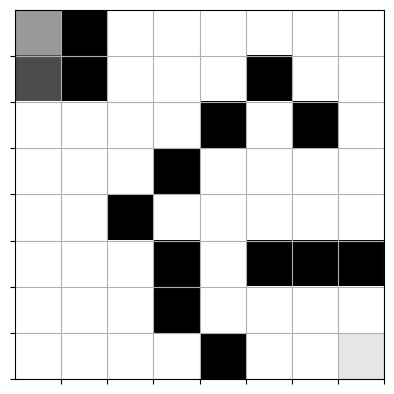

In [38]:
qmaze = TreasureMaze(maze, 256)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [39]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
#         q = model.predict(prev_envstate)
#         action = np.argmax(q[0])
        q = model(envstate, training=False).numpy()[0]
        action = choose_action_greedy_masked(q, qmaze.valid_actions())
        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [40]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [41]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [42]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 
    
    epsilon_min = 0.05       # Epsilon low threshold
    epsilon_decay = 0.997    # Epsilon decay rate per episode
    MAX_STEPS = 256          # Step cap to limit wandering

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)
    
    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze, MAX_STEPS, pirate=(0,0))

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
  
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0

    min_memory  = max(200, data_size)  # warm up replay before first update
    train_every = 4                    # update every 4 steps (try 4–10)
    batch_size  = data_size            # e.g., 32–128
    
    
    #  Iterates through each epoch
    for epoch in range(n_epoch):

        # Initialize loss, pick random cell, and set up environment
        loss = float('nan')
        random_free_cell = qmaze.free_cells[random.randint(0, len(qmaze.free_cells) - 1)]
        agent_cell = random_free_cell
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()
        n_episodes = 0
        
        # Counts steps for cap
        steps = 0
        
        # Loop runs until game is lost or won
        while qmaze.game_status() == 'not_over' :
            steps += 1
            n_episodes += 1
            
            # Stores current environment and picks random number for a valid action
            previous_envstate = envstate
            random_number = random.random()
            valid = qmaze.valid_actions()
            
            # Exploration path
            if random_number <= epsilon:
                action = random.choice(valid)  
                envstate, reward, game_status = qmaze.act(action)
            
            # Exploitation path
            else:
                q = model(previous_envstate, training=False).numpy()[0]
                action = choose_action_greedy_masked(q, valid)
                envstate, reward, game_status = qmaze.act(action)
                
            # Saves episode to memory for future learning    
            done = (game_status != 'not_over')    
            episode = [previous_envstate, action, reward, envstate, done]
            experience.remember(episode)
            
            # Trains the model at the desired interval
            if len(experience.memory) >= min_memory and (n_episodes % train_every == 0):
                inputs, targets = get_data_with_target(experience, data_size=batch_size, target=target_model)
                if inputs is not None:
                    hist = model.fit(inputs, targets, epochs=1, batch_size=batch_size, verbose=0)
                    loss = float(hist.history['loss'][-1])
                    update_target(model, target_model, TAU)

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Adds win or loss to history
        game_status = qmaze.game_status()
        if game_status == 'lose':
            win_history.append(0)
        else:
            win_history.append(1)
            
        win_rate = sum(win_history) / len(win_history)
            
        

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        print("Epsilon: " + str(epsilon))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        #if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    
    return seconds


# Helper for choosing valid actions
def choose_action_greedy_masked(q_values, valid_actions):
    # q_values: shape (num_actions,)
    mask = np.full_like(q_values, -1e9, dtype=np.float32)
    mask[valid_actions] = q_values[valid_actions]
    return int(np.argmax(mask))



# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

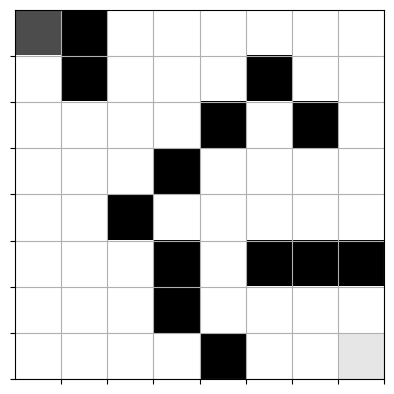

In [43]:
qmaze = TreasureMaze(maze, 256)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [44]:
def randomly_select_free_cell(qmaze):
    # Find all free (non-wall) cells in the maze
    free_cells = [(r, c) for r in range(qmaze.rows)
                         for c in range(qmaze.cols)
                         if qmaze.maze[r, c] == 0]  # assuming 0 means free
    return random.choice(free_cells)

In [45]:
model = build_model(maze)

# target model: same arch, starts identical
target_model = build_model(maze)
target_model.set_weights(model.get_weights())

model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),  # clipvalue=1.0 also fine
              loss=Huber())


In [46]:
# Soft update: target ← τ*online + (1-τ)*target
TAU = 0.01  # try 0.005–0.02

def update_target(online_model, target_model, tau=TAU):
    w  = online_model.get_weights()
    wt = target_model.get_weights()
    for i in range(len(w)):
        wt[i] = tau * w[i] + (1.0 - tau) * wt[i]
    target_model.set_weights(wt)

# Use target model ONLY for Q(s', ·) inside existing GameExperience.get_data
def get_data_with_target(memory, data_size=32, target=target_model):
    original = memory.model                # memory.model is used by memory.predict(...) in get_data
    memory.model = target                  # temporarily point to target for bootstrapping
    try:
        X, y = memory.get_data(data_size=data_size)
    finally:
        memory.model = original            # restore to online model
    return X, y

In [ ]:
qtrain(model, maze, n_epoch=15000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: nan | Episodes: 16 | Win count: 1 | Win rate: 1.000 | time: 0.0 seconds
Epsilon: 0.997
Epoch: 001/14999 | Loss: nan | Episodes: 147 | Win count: 1 | Win rate: 0.500 | time: 0.0 seconds
Epsilon: 0.994009
Epoch: 002/14999 | Loss: 0.0045 | Episodes: 144 | Win count: 1 | Win rate: 0.333 | time: 13.5 seconds
Epsilon: 0.991026973
Epoch: 003/14999 | Loss: 0.0043 | Episodes: 146 | Win count: 1 | Win rate: 0.250 | time: 28.9 seconds
Epsilon: 0.988053892081
Epoch: 004/14999 | Loss: 0.0039 | Episodes: 156 | Win count: 1 | Win rate: 0.200 | time: 45.4 seconds
Epsilon: 0.985089730404757
Epoch: 005/14999 | Loss: 0.0038 | Episodes: 151 | Win count: 1 | Win rate: 0.167 | time: 60.9 seconds
Epsilon: 0.9821344612135428
Epoch: 006/14999 | Loss: 0.0052 | Episodes: 122 | Win count: 2 | Win rate: 0.286 | time: 76.3 seconds
Epsilon: 0.9791880578299021
Epoch: 007/14999 | Loss: 0.0033 | Episodes: 21 | Win count: 3 | Win rate: 0.375 | time: 78.6 seconds
Epsilon: 0.9762504936564125
Epoch

Epoch: 065/14999 | Loss: 0.0033 | Episodes: 158 | Win count: 19 | Win rate: 0.288 | time: 16.29 minutes
Epsilon: 0.8201257512162927
Epoch: 066/14999 | Loss: nan | Episodes: 2 | Win count: 20 | Win rate: 0.299 | time: 16.29 minutes
Epsilon: 0.8176653739626438
Epoch: 067/14999 | Loss: 0.0035 | Episodes: 150 | Win count: 20 | Win rate: 0.294 | time: 16.56 minutes
Epsilon: 0.8152123778407558
Epoch: 068/14999 | Loss: 0.0028 | Episodes: 4 | Win count: 21 | Win rate: 0.304 | time: 16.57 minutes
Epsilon: 0.8127667407072335
Epoch: 069/14999 | Loss: 0.0038 | Episodes: 140 | Win count: 21 | Win rate: 0.300 | time: 16.82 minutes
Epsilon: 0.8103284404851119
Epoch: 070/14999 | Loss: 0.0036 | Episodes: 149 | Win count: 21 | Win rate: 0.296 | time: 17.09 minutes
Epsilon: 0.8078974551636565
Epoch: 071/14999 | Loss: 0.0031 | Episodes: 50 | Win count: 22 | Win rate: 0.306 | time: 17.19 minutes
Epsilon: 0.8054737627981655
Epoch: 072/14999 | Loss: 0.0027 | Episodes: 5 | Win count: 23 | Win rate: 0.315 | ti

Epoch: 128/14999 | Loss: 0.0024 | Episodes: 137 | Win count: 38 | Win rate: 0.295 | time: 30.86 minutes
Epsilon: 0.6786962072000923
Epoch: 129/14999 | Loss: 0.0030 | Episodes: 150 | Win count: 38 | Win rate: 0.292 | time: 31.20 minutes
Epsilon: 0.676660118578492
Epoch: 130/14999 | Loss: 0.0038 | Episodes: 148 | Win count: 39 | Win rate: 0.298 | time: 31.55 minutes
Epsilon: 0.6746301382227565
Epoch: 131/14999 | Loss: 0.0022 | Episodes: 11 | Win count: 40 | Win rate: 0.303 | time: 31.57 minutes
Epsilon: 0.6726062478080883
Epoch: 132/14999 | Loss: 0.0110 | Episodes: 149 | Win count: 40 | Win rate: 0.301 | time: 31.91 minutes
Epsilon: 0.6705884290646641
Epoch: 133/14999 | Loss: 0.0055 | Episodes: 154 | Win count: 40 | Win rate: 0.299 | time: 32.27 minutes
Epsilon: 0.66857666377747
Epoch: 134/14999 | Loss: 0.0021 | Episodes: 145 | Win count: 40 | Win rate: 0.296 | time: 32.60 minutes
Epsilon: 0.6665709337861376
Epoch: 135/14999 | Loss: 0.0022 | Episodes: 147 | Win count: 40 | Win rate: 0.29

Epoch: 191/14999 | Loss: 0.0019 | Episodes: 139 | Win count: 60 | Win rate: 0.312 | time: 48.03 minutes
Epsilon: 0.5616559911509333
Epoch: 192/14999 | Loss: 0.0013 | Episodes: 137 | Win count: 60 | Win rate: 0.311 | time: 48.37 minutes
Epsilon: 0.5599710231774805
Epoch: 193/14999 | Loss: 0.0011 | Episodes: 139 | Win count: 60 | Win rate: 0.309 | time: 48.75 minutes
Epsilon: 0.5582911101079481
Epoch: 194/14999 | Loss: 0.0016 | Episodes: 137 | Win count: 60 | Win rate: 0.308 | time: 49.12 minutes
Epsilon: 0.5566162367776242
Epoch: 195/14999 | Loss: 0.0033 | Episodes: 9 | Win count: 61 | Win rate: 0.311 | time: 49.14 minutes
Epsilon: 0.5549463880672914
Epoch: 196/14999 | Loss: 0.0013 | Episodes: 162 | Win count: 61 | Win rate: 0.310 | time: 49.60 minutes
Epsilon: 0.5532815489030894
Epoch: 197/14999 | Loss: 0.0020 | Episodes: 151 | Win count: 61 | Win rate: 0.308 | time: 50.04 minutes
Epsilon: 0.5516217042563801
Epoch: 198/14999 | Loss: 0.0018 | Episodes: 136 | Win count: 61 | Win rate: 0.

Epoch: 254/14999 | Loss: 0.0003 | Episodes: 135 | Win count: 78 | Win rate: 0.306 | time: 65.68 minutes
Epsilon: 0.4647991974157809
Epoch: 255/14999 | Loss: 0.0014 | Episodes: 137 | Win count: 78 | Win rate: 0.305 | time: 66.06 minutes
Epsilon: 0.46340479982353355
Epoch: 256/14999 | Loss: 0.0007 | Episodes: 143 | Win count: 78 | Win rate: 0.304 | time: 66.41 minutes
Epsilon: 0.46201458542406293
Epoch: 257/14999 | Loss: 0.0004 | Episodes: 135 | Win count: 78 | Win rate: 0.302 | time: 1.11 hours
Epsilon: 0.4606285416677907
Epoch: 258/14999 | Loss: 0.0011 | Episodes: 10 | Win count: 79 | Win rate: 0.305 | time: 1.11 hours
Epsilon: 0.45924665604278736
Epoch: 259/14999 | Loss: 0.0010 | Episodes: 141 | Win count: 79 | Win rate: 0.304 | time: 1.12 hours
Epsilon: 0.457868916074659
Epoch: 260/14999 | Loss: 0.0008 | Episodes: 137 | Win count: 79 | Win rate: 0.303 | time: 1.12 hours
Epsilon: 0.45649530932643506
Epoch: 261/14999 | Loss: 0.0013 | Episodes: 142 | Win count: 79 | Win rate: 0.302 | ti

Epoch: 318/14999 | Loss: 0.0066 | Episodes: 144 | Win count: 95 | Win rate: 0.298 | time: 1.37 hours
Epsilon: 0.3834912872472453
Epoch: 319/14999 | Loss: 0.0006 | Episodes: 147 | Win count: 95 | Win rate: 0.297 | time: 1.37 hours
Epsilon: 0.3823408133855036
Epoch: 320/14999 | Loss: 0.0013 | Episodes: 7 | Win count: 96 | Win rate: 0.299 | time: 1.37 hours
Epsilon: 0.38119379094534706
Epoch: 321/14999 | Loss: 0.0008 | Episodes: 133 | Win count: 96 | Win rate: 0.298 | time: 1.38 hours
Epsilon: 0.380050209572511
Epoch: 322/14999 | Loss: 0.0010 | Episodes: 139 | Win count: 96 | Win rate: 0.297 | time: 1.38 hours
Epsilon: 0.3789100589437935
Epoch: 323/14999 | Loss: 0.0010 | Episodes: 134 | Win count: 96 | Win rate: 0.296 | time: 1.39 hours
Epsilon: 0.3777733287669621
Epoch: 324/14999 | Loss: 0.0007 | Episodes: 135 | Win count: 96 | Win rate: 0.295 | time: 1.39 hours
Epsilon: 0.37664000878066123
Epoch: 325/14999 | Loss: 0.0007 | Episodes: 142 | Win count: 96 | Win rate: 0.294 | time: 1.40 hou

Epoch: 382/14999 | Loss: 0.0004 | Episodes: 134 | Win count: 113 | Win rate: 0.295 | time: 1.67 hours
Epsilon: 0.316406672412976
Epoch: 383/14999 | Loss: 0.0059 | Episodes: 137 | Win count: 113 | Win rate: 0.294 | time: 1.68 hours
Epsilon: 0.3154574523957371
Epoch: 384/14999 | Loss: 0.0008 | Episodes: 135 | Win count: 113 | Win rate: 0.294 | time: 1.68 hours
Epsilon: 0.3145110800385499
Epoch: 385/14999 | Loss: 0.0004 | Episodes: 134 | Win count: 113 | Win rate: 0.293 | time: 1.69 hours
Epsilon: 0.31356754679843424
Epoch: 386/14999 | Loss: 0.0010 | Episodes: 138 | Win count: 113 | Win rate: 0.292 | time: 1.70 hours
Epsilon: 0.31262684415803893
Epoch: 387/14999 | Loss: nan | Episodes: 1 | Win count: 114 | Win rate: 0.294 | time: 1.70 hours
Epsilon: 0.3116889636255648
Epoch: 388/14999 | Loss: 0.0008 | Episodes: 136 | Win count: 114 | Win rate: 0.293 | time: 1.70 hours
Epsilon: 0.3107538967346881
Epoch: 389/14999 | Loss: 0.0014 | Episodes: 15 | Win count: 115 | Win rate: 0.295 | time: 1.70

Epoch: 446/14999 | Loss: 0.0007 | Episodes: 134 | Win count: 134 | Win rate: 0.300 | time: 2.02 hours
Epsilon: 0.26105725391071816
Epoch: 447/14999 | Loss: nan | Episodes: 3 | Win count: 135 | Win rate: 0.301 | time: 2.02 hours
Epsilon: 0.260274082148986
Epoch: 448/14999 | Loss: 0.0009 | Episodes: 23 | Win count: 136 | Win rate: 0.303 | time: 2.02 hours
Epsilon: 0.2594932599025391
Epoch: 449/14999 | Loss: 0.0005 | Episodes: 143 | Win count: 136 | Win rate: 0.302 | time: 2.03 hours
Epsilon: 0.25871478012283144
Epoch: 450/14999 | Loss: 0.0054 | Episodes: 134 | Win count: 136 | Win rate: 0.302 | time: 2.04 hours
Epsilon: 0.25793863578246295
Epoch: 451/14999 | Loss: 0.0007 | Episodes: 135 | Win count: 136 | Win rate: 0.301 | time: 2.05 hours
Epsilon: 0.2571648198751156
Epoch: 452/14999 | Loss: 0.0004 | Episodes: 147 | Win count: 137 | Win rate: 0.302 | time: 2.06 hours
Epsilon: 0.25639332541549026
Epoch: 453/14999 | Loss: 0.0011 | Episodes: 144 | Win count: 137 | Win rate: 0.302 | time: 2.

Epoch: 509/14999 | Loss: 0.0011 | Episodes: 133 | Win count: 151 | Win rate: 0.296 | time: 2.50 hours
Epsilon: 0.21603829391835358
Epoch: 510/14999 | Loss: 0.0004 | Episodes: 8 | Win count: 152 | Win rate: 0.297 | time: 2.50 hours
Epsilon: 0.21539017903659852
Epoch: 511/14999 | Loss: 0.0011 | Episodes: 8 | Win count: 153 | Win rate: 0.299 | time: 2.51 hours
Epsilon: 0.21474400849948871
Epoch: 512/14999 | Loss: 0.0013 | Episodes: 4 | Win count: 154 | Win rate: 0.300 | time: 2.51 hours
Epsilon: 0.21409977647399026
Epoch: 513/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 154 | Win rate: 0.300 | time: 2.52 hours
Epsilon: 0.21345747714456828
Epoch: 514/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 154 | Win rate: 0.299 | time: 2.53 hours
Epsilon: 0.21281710471313459
Epoch: 515/14999 | Loss: 0.0009 | Episodes: 7 | Win count: 155 | Win rate: 0.300 | time: 2.53 hours
Epsilon: 0.2121786533989952
Epoch: 516/14999 | Loss: 0.0003 | Episodes: 141 | Win count: 155 | Win rate: 0.300 | time: 2

Epoch: 573/14999 | Loss: 0.0015 | Episodes: 105 | Win count: 179 | Win rate: 0.312 | time: 3.24 hours
Epsilon: 0.17824644252846386
Epoch: 574/14999 | Loss: 0.0004 | Episodes: 134 | Win count: 179 | Win rate: 0.311 | time: 3.26 hours
Epsilon: 0.17771170320087848
Epoch: 575/14999 | Loss: 0.0002 | Episodes: 135 | Win count: 179 | Win rate: 0.311 | time: 3.28 hours
Epsilon: 0.17717856809127586
Epoch: 576/14999 | Loss: 0.0005 | Episodes: 133 | Win count: 179 | Win rate: 0.310 | time: 3.30 hours
Epsilon: 0.17664703238700202
Epoch: 577/14999 | Loss: 0.0022 | Episodes: 134 | Win count: 179 | Win rate: 0.310 | time: 3.32 hours
Epsilon: 0.17611709128984102
Epoch: 578/14999 | Loss: 0.0007 | Episodes: 138 | Win count: 179 | Win rate: 0.309 | time: 3.34 hours
Epsilon: 0.1755887400159715
Epoch: 579/14999 | Loss: 0.0039 | Episodes: 139 | Win count: 179 | Win rate: 0.309 | time: 3.37 hours
Epsilon: 0.1750619737959236
Epoch: 580/14999 | Loss: 0.0008 | Episodes: 7 | Win count: 180 | Win rate: 0.310 | ti

Epoch: 637/14999 | Loss: 0.0011 | Episodes: 27 | Win count: 208 | Win rate: 0.326 | time: 4.15 hours
Epsilon: 0.14706556739454882
Epoch: 638/14999 | Loss: 0.0008 | Episodes: 134 | Win count: 208 | Win rate: 0.326 | time: 4.17 hours
Epsilon: 0.14662437069236517
Epoch: 639/14999 | Loss: 0.0007 | Episodes: 133 | Win count: 208 | Win rate: 0.325 | time: 4.20 hours
Epsilon: 0.14618449758028806
Epoch: 640/14999 | Loss: 0.0013 | Episodes: 22 | Win count: 209 | Win rate: 0.326 | time: 4.20 hours
Epsilon: 0.1457459440875472
Epoch: 641/14999 | Loss: 0.0006 | Episodes: 134 | Win count: 209 | Win rate: 0.326 | time: 4.23 hours
Epsilon: 0.14530870625528455
Epoch: 642/14999 | Loss: 0.0014 | Episodes: 35 | Win count: 210 | Win rate: 0.327 | time: 4.23 hours
Epsilon: 0.1448727801365187
Epoch: 643/14999 | Loss: nan | Episodes: 3 | Win count: 211 | Win rate: 0.328 | time: 4.23 hours
Epsilon: 0.14443816179610913
Epoch: 644/14999 | Loss: 0.0007 | Episodes: 4 | Win count: 212 | Win rate: 0.329 | time: 4.24

Epoch: 701/14999 | Loss: 0.0025 | Episodes: 135 | Win count: 257 | Win rate: 0.366 | time: 4.74 hours
Epsilon: 0.12133920209726937
Epoch: 702/14999 | Loss: 0.0013 | Episodes: 14 | Win count: 258 | Win rate: 0.367 | time: 4.74 hours
Epsilon: 0.12097518449097756
Epoch: 703/14999 | Loss: 0.0038 | Episodes: 55 | Win count: 259 | Win rate: 0.368 | time: 4.76 hours
Epsilon: 0.12061225893750463
Epoch: 704/14999 | Loss: nan | Episodes: 3 | Win count: 260 | Win rate: 0.369 | time: 4.76 hours
Epsilon: 0.12025042216069212
Epoch: 705/14999 | Loss: 0.0031 | Episodes: 31 | Win count: 261 | Win rate: 0.370 | time: 4.76 hours
Epsilon: 0.11988967089421004
Epoch: 706/14999 | Loss: 0.0011 | Episodes: 134 | Win count: 261 | Win rate: 0.369 | time: 4.79 hours
Epsilon: 0.11953000188152742
Epoch: 707/14999 | Loss: 0.0006 | Episodes: 9 | Win count: 262 | Win rate: 0.370 | time: 4.79 hours
Epsilon: 0.11917141187588283
Epoch: 708/14999 | Loss: 0.0014 | Episodes: 9 | Win count: 263 | Win rate: 0.371 | time: 4.79

Epoch: 766/14999 | Loss: 0.0011 | Episodes: 27 | Win count: 311 | Win rate: 0.405 | time: 5.18 hours
Epsilon: 0.0998128428004098
Epoch: 767/14999 | Loss: 0.0003 | Episodes: 134 | Win count: 311 | Win rate: 0.405 | time: 5.20 hours
Epsilon: 0.09951340427200858
Epoch: 768/14999 | Loss: 0.0011 | Episodes: 17 | Win count: 312 | Win rate: 0.406 | time: 5.20 hours
Epsilon: 0.09921486405919255
Epoch: 769/14999 | Loss: 0.0020 | Episodes: 133 | Win count: 312 | Win rate: 0.405 | time: 5.22 hours
Epsilon: 0.09891721946701497
Epoch: 770/14999 | Loss: 0.0002 | Episodes: 12 | Win count: 313 | Win rate: 0.406 | time: 5.23 hours
Epsilon: 0.09862046780861393
Epoch: 771/14999 | Loss: 0.0021 | Episodes: 16 | Win count: 314 | Win rate: 0.407 | time: 5.23 hours
Epsilon: 0.09832460640518809
Epoch: 772/14999 | Loss: 0.0003 | Episodes: 18 | Win count: 315 | Win rate: 0.408 | time: 5.23 hours
Epsilon: 0.09802963258597253
Epoch: 773/14999 | Loss: 0.0016 | Episodes: 20 | Win count: 316 | Win rate: 0.408 | time:

Epoch: 830/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 364 | Win rate: 0.438 | time: 5.55 hours
Epsilon: 0.0823524562481022
Epoch: 831/14999 | Loss: 0.0013 | Episodes: 21 | Win count: 365 | Win rate: 0.439 | time: 5.55 hours
Epsilon: 0.08210539887935789
Epoch: 832/14999 | Loss: nan | Episodes: 2 | Win count: 366 | Win rate: 0.439 | time: 5.55 hours
Epsilon: 0.08185908268271981
Epoch: 833/14999 | Loss: 0.0019 | Episodes: 14 | Win count: 367 | Win rate: 0.440 | time: 5.55 hours
Epsilon: 0.08161350543467165
Epoch: 834/14999 | Loss: 0.0012 | Episodes: 23 | Win count: 368 | Win rate: 0.441 | time: 5.55 hours
Epsilon: 0.08136866491836764
Epoch: 835/14999 | Loss: 0.0009 | Episodes: 133 | Win count: 368 | Win rate: 0.440 | time: 5.57 hours
Epsilon: 0.08112455892361253
Epoch: 836/14999 | Loss: 0.0004 | Episodes: 14 | Win count: 369 | Win rate: 0.441 | time: 5.57 hours
Epsilon: 0.0808811852468417
Epoch: 837/14999 | Loss: nan | Episodes: 3 | Win count: 370 | Win rate: 0.442 | time: 5.57 hour

Epoch: 894/14999 | Loss: 0.0005 | Episodes: 132 | Win count: 418 | Win rate: 0.467 | time: 5.80 hours
Epsilon: 0.06794643714994701
Epoch: 895/14999 | Loss: 0.0005 | Episodes: 9 | Win count: 419 | Win rate: 0.468 | time: 5.81 hours
Epsilon: 0.06774259783849718
Epoch: 896/14999 | Loss: 0.0010 | Episodes: 10 | Win count: 420 | Win rate: 0.468 | time: 5.81 hours
Epsilon: 0.06753937004498169
Epoch: 897/14999 | Loss: nan | Episodes: 1 | Win count: 421 | Win rate: 0.469 | time: 5.81 hours
Epsilon: 0.06733675193484674
Epoch: 898/14999 | Loss: nan | Episodes: 2 | Win count: 422 | Win rate: 0.469 | time: 5.81 hours
Epsilon: 0.0671347416790422
Epoch: 899/14999 | Loss: nan | Episodes: 1 | Win count: 423 | Win rate: 0.470 | time: 5.81 hours
Epsilon: 0.06693333745400507
Epoch: 900/14999 | Loss: nan | Episodes: 3 | Win count: 424 | Win rate: 0.471 | time: 5.81 hours
Epsilon: 0.06673253744164305
Epoch: 901/14999 | Loss: 0.0015 | Episodes: 18 | Win count: 425 | Win rate: 0.471 | time: 5.81 hours
Epsilo

Epoch: 958/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 471 | Win rate: 0.491 | time: 6.13 hours
Epsilon: 0.056060481152656466
Epoch: 959/14999 | Loss: 0.0003 | Episodes: 9 | Win count: 472 | Win rate: 0.492 | time: 6.14 hours
Epsilon: 0.0558922997091985
Epoch: 960/14999 | Loss: 0.0031 | Episodes: 16 | Win count: 473 | Win rate: 0.492 | time: 6.14 hours
Epsilon: 0.0557246228100709
Epoch: 961/14999 | Loss: 0.0006 | Episodes: 13 | Win count: 474 | Win rate: 0.493 | time: 6.14 hours
Epsilon: 0.055557448941640684
Epoch: 962/14999 | Loss: 0.0002 | Episodes: 8 | Win count: 475 | Win rate: 0.493 | time: 6.14 hours
Epsilon: 0.05539077659481576
Epoch: 963/14999 | Loss: 0.0004 | Episodes: 23 | Win count: 476 | Win rate: 0.494 | time: 6.14 hours
Epsilon: 0.05522460426503131
Epoch: 964/14999 | Loss: nan | Episodes: 3 | Win count: 477 | Win rate: 0.494 | time: 6.14 hours
Epsilon: 0.05505893045223622
Epoch: 965/14999 | Loss: 0.0031 | Episodes: 9 | Win count: 478 | Win rate: 0.495 | time: 6.15 ho

Epoch: 1025/14999 | Loss: 0.0003 | Episodes: 133 | Win count: 523 | Win rate: 0.510 | time: 6.55 hours
Epsilon: 0.05
Epoch: 1026/14999 | Loss: 0.0000 | Episodes: 133 | Win count: 523 | Win rate: 0.509 | time: 6.58 hours
Epsilon: 0.05
Epoch: 1027/14999 | Loss: 0.0001 | Episodes: 18 | Win count: 524 | Win rate: 0.510 | time: 6.58 hours
Epsilon: 0.05
Epoch: 1028/14999 | Loss: 0.0003 | Episodes: 133 | Win count: 524 | Win rate: 0.509 | time: 6.60 hours
Epsilon: 0.05
Epoch: 1029/14999 | Loss: 0.0003 | Episodes: 7 | Win count: 525 | Win rate: 0.510 | time: 6.60 hours
Epsilon: 0.05
Epoch: 1030/14999 | Loss: 0.0035 | Episodes: 19 | Win count: 526 | Win rate: 0.510 | time: 6.60 hours
Epsilon: 0.05
Epoch: 1031/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 527 | Win rate: 0.511 | time: 6.61 hours
Epsilon: 0.05
Epoch: 1032/14999 | Loss: 0.0003 | Episodes: 20 | Win count: 528 | Win rate: 0.511 | time: 6.61 hours
Epsilon: 0.05
Epoch: 1033/14999 | Loss: 0.0023 | Episodes: 19 | Win count: 529 | Win

Epoch: 1096/14999 | Loss: 0.0004 | Episodes: 21 | Win count: 577 | Win rate: 0.526 | time: 7.35 hours
Epsilon: 0.05
Epoch: 1097/14999 | Loss: 0.0005 | Episodes: 9 | Win count: 578 | Win rate: 0.526 | time: 7.35 hours
Epsilon: 0.05
Epoch: 1098/14999 | Loss: 0.0017 | Episodes: 9 | Win count: 579 | Win rate: 0.527 | time: 7.36 hours
Epsilon: 0.05
Epoch: 1099/14999 | Loss: nan | Episodes: 3 | Win count: 580 | Win rate: 0.527 | time: 7.36 hours
Epsilon: 0.05
Epoch: 1100/14999 | Loss: 0.0029 | Episodes: 21 | Win count: 581 | Win rate: 0.528 | time: 7.36 hours
Epsilon: 0.05
Epoch: 1101/14999 | Loss: 0.0003 | Episodes: 133 | Win count: 581 | Win rate: 0.527 | time: 7.39 hours
Epsilon: 0.05
Epoch: 1102/14999 | Loss: 0.0008 | Episodes: 9 | Win count: 582 | Win rate: 0.528 | time: 7.39 hours
Epsilon: 0.05
Epoch: 1103/14999 | Loss: 0.0036 | Episodes: 134 | Win count: 582 | Win rate: 0.527 | time: 7.42 hours
Epsilon: 0.05
Epoch: 1104/14999 | Loss: 0.0007 | Episodes: 18 | Win count: 583 | Win rate: 

Epoch: 1167/14999 | Loss: 0.0001 | Episodes: 134 | Win count: 633 | Win rate: 0.542 | time: 7.93 hours
Epsilon: 0.05
Epoch: 1168/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 634 | Win rate: 0.542 | time: 7.94 hours
Epsilon: 0.05
Epoch: 1169/14999 | Loss: 0.0017 | Episodes: 130 | Win count: 634 | Win rate: 0.542 | time: 7.95 hours
Epsilon: 0.05
Epoch: 1170/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 635 | Win rate: 0.542 | time: 7.96 hours
Epsilon: 0.05
Epoch: 1171/14999 | Loss: nan | Episodes: 2 | Win count: 636 | Win rate: 0.543 | time: 7.96 hours
Epsilon: 0.05
Epoch: 1172/14999 | Loss: 0.0002 | Episodes: 13 | Win count: 637 | Win rate: 0.543 | time: 7.96 hours
Epsilon: 0.05
Epoch: 1173/14999 | Loss: nan | Episodes: 2 | Win count: 638 | Win rate: 0.543 | time: 7.96 hours
Epsilon: 0.05
Epoch: 1174/14999 | Loss: 0.0001 | Episodes: 16 | Win count: 639 | Win rate: 0.544 | time: 7.96 hours
Epsilon: 0.05
Epoch: 1175/14999 | Loss: 0.0006 | Episodes: 8 | Win count: 640 | Win rate: 0.

Epoch: 1238/14999 | Loss: 0.0017 | Episodes: 4 | Win count: 689 | Win rate: 0.556 | time: 8.37 hours
Epsilon: 0.05
Epoch: 1239/14999 | Loss: 0.0003 | Episodes: 134 | Win count: 689 | Win rate: 0.556 | time: 8.39 hours
Epsilon: 0.05
Epoch: 1240/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 690 | Win rate: 0.556 | time: 8.39 hours
Epsilon: 0.05
Epoch: 1241/14999 | Loss: 0.0002 | Episodes: 8 | Win count: 691 | Win rate: 0.556 | time: 8.39 hours
Epsilon: 0.05
Epoch: 1242/14999 | Loss: 0.0001 | Episodes: 133 | Win count: 691 | Win rate: 0.556 | time: 8.41 hours
Epsilon: 0.05
Epoch: 1243/14999 | Loss: 0.0002 | Episodes: 8 | Win count: 692 | Win rate: 0.556 | time: 8.42 hours
Epsilon: 0.05
Epoch: 1244/14999 | Loss: 0.0012 | Episodes: 17 | Win count: 693 | Win rate: 0.557 | time: 8.42 hours
Epsilon: 0.05
Epoch: 1245/14999 | Loss: 0.0001 | Episodes: 7 | Win count: 694 | Win rate: 0.557 | time: 8.42 hours
Epsilon: 0.05
Epoch: 1246/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 695 | Win rat

Epoch: 1310/14999 | Loss: 0.0013 | Episodes: 25 | Win count: 739 | Win rate: 0.564 | time: 8.91 hours
Epsilon: 0.05
Epoch: 1311/14999 | Loss: 0.0007 | Episodes: 9 | Win count: 740 | Win rate: 0.564 | time: 8.91 hours
Epsilon: 0.05
Epoch: 1312/14999 | Loss: 0.0026 | Episodes: 18 | Win count: 741 | Win rate: 0.564 | time: 8.91 hours
Epsilon: 0.05
Epoch: 1313/14999 | Loss: 0.0002 | Episodes: 15 | Win count: 742 | Win rate: 0.565 | time: 8.91 hours
Epsilon: 0.05
Epoch: 1314/14999 | Loss: 0.0002 | Episodes: 11 | Win count: 743 | Win rate: 0.565 | time: 8.92 hours
Epsilon: 0.05
Epoch: 1315/14999 | Loss: 0.0001 | Episodes: 9 | Win count: 744 | Win rate: 0.565 | time: 8.92 hours
Epsilon: 0.05
Epoch: 1316/14999 | Loss: 0.0001 | Episodes: 133 | Win count: 744 | Win rate: 0.565 | time: 8.93 hours
Epsilon: 0.05
Epoch: 1317/14999 | Loss: 0.0002 | Episodes: 9 | Win count: 745 | Win rate: 0.565 | time: 8.93 hours
Epsilon: 0.05
Epoch: 1318/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 746 | Win rat

Epoch: 1381/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 796 | Win rate: 0.576 | time: 9.26 hours
Epsilon: 0.05
Epoch: 1382/14999 | Loss: 0.0015 | Episodes: 25 | Win count: 797 | Win rate: 0.576 | time: 9.27 hours
Epsilon: 0.05
Epoch: 1383/14999 | Loss: 0.0025 | Episodes: 18 | Win count: 798 | Win rate: 0.577 | time: 9.27 hours
Epsilon: 0.05
Epoch: 1384/14999 | Loss: 0.0005 | Episodes: 13 | Win count: 799 | Win rate: 0.577 | time: 9.27 hours
Epsilon: 0.05
Epoch: 1385/14999 | Loss: 0.0002 | Episodes: 19 | Win count: 800 | Win rate: 0.577 | time: 9.27 hours
Epsilon: 0.05
Epoch: 1386/14999 | Loss: 0.0001 | Episodes: 132 | Win count: 800 | Win rate: 0.577 | time: 9.29 hours
Epsilon: 0.05
Epoch: 1387/14999 | Loss: 0.0001 | Episodes: 132 | Win count: 800 | Win rate: 0.576 | time: 9.31 hours
Epsilon: 0.05
Epoch: 1388/14999 | Loss: 0.0009 | Episodes: 15 | Win count: 801 | Win rate: 0.577 | time: 9.31 hours
Epsilon: 0.05
Epoch: 1389/14999 | Loss: 0.0003 | Episodes: 12 | Win count: 802 | Win

Epoch: 1452/14999 | Loss: 0.0001 | Episodes: 23 | Win count: 854 | Win rate: 0.588 | time: 9.55 hours
Epsilon: 0.05
Epoch: 1453/14999 | Loss: 0.0002 | Episodes: 79 | Win count: 855 | Win rate: 0.588 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1454/14999 | Loss: 0.0001 | Episodes: 11 | Win count: 856 | Win rate: 0.588 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1455/14999 | Loss: 0.0003 | Episodes: 25 | Win count: 857 | Win rate: 0.589 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1456/14999 | Loss: nan | Episodes: 1 | Win count: 858 | Win rate: 0.589 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1457/14999 | Loss: 0.0001 | Episodes: 15 | Win count: 859 | Win rate: 0.589 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1458/14999 | Loss: 0.0007 | Episodes: 20 | Win count: 860 | Win rate: 0.589 | time: 9.56 hours
Epsilon: 0.05
Epoch: 1459/14999 | Loss: 0.0001 | Episodes: 8 | Win count: 861 | Win rate: 0.590 | time: 9.57 hours
Epsilon: 0.05
Epoch: 1460/14999 | Loss: 0.0005 | Episodes: 13 | Win count: 862 | Win rate: 

Epoch: 1523/14999 | Loss: 0.0002 | Episodes: 21 | Win count: 915 | Win rate: 0.600 | time: 9.78 hours
Epsilon: 0.05
Epoch: 1524/14999 | Loss: 0.0006 | Episodes: 18 | Win count: 916 | Win rate: 0.601 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1525/14999 | Loss: 0.0002 | Episodes: 15 | Win count: 917 | Win rate: 0.601 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1526/14999 | Loss: nan | Episodes: 1 | Win count: 918 | Win rate: 0.601 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1527/14999 | Loss: nan | Episodes: 1 | Win count: 919 | Win rate: 0.601 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1528/14999 | Loss: 0.0004 | Episodes: 22 | Win count: 920 | Win rate: 0.602 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1529/14999 | Loss: 0.0005 | Episodes: 23 | Win count: 921 | Win rate: 0.602 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1530/14999 | Loss: 0.0004 | Episodes: 21 | Win count: 922 | Win rate: 0.602 | time: 9.79 hours
Epsilon: 0.05
Epoch: 1531/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 923 | Win rate: 0.6

Epoch: 1594/14999 | Loss: 0.0001 | Episodes: 4 | Win count: 974 | Win rate: 0.611 | time: 10.08 hours
Epsilon: 0.05
Epoch: 1595/14999 | Loss: 0.0005 | Episodes: 133 | Win count: 974 | Win rate: 0.610 | time: 10.10 hours
Epsilon: 0.05
Epoch: 1596/14999 | Loss: nan | Episodes: 1 | Win count: 975 | Win rate: 0.611 | time: 10.10 hours
Epsilon: 0.05
Epoch: 1597/14999 | Loss: 0.0002 | Episodes: 12 | Win count: 976 | Win rate: 0.611 | time: 10.10 hours
Epsilon: 0.05
Epoch: 1598/14999 | Loss: 0.0003 | Episodes: 134 | Win count: 976 | Win rate: 0.610 | time: 10.12 hours
Epsilon: 0.05
Epoch: 1599/14999 | Loss: 0.0001 | Episodes: 133 | Win count: 976 | Win rate: 0.610 | time: 10.14 hours
Epsilon: 0.05
Epoch: 1600/14999 | Loss: 0.0004 | Episodes: 23 | Win count: 977 | Win rate: 0.610 | time: 10.14 hours
Epsilon: 0.05
Epoch: 1601/14999 | Loss: 0.0001 | Episodes: 19 | Win count: 978 | Win rate: 0.610 | time: 10.15 hours
Epsilon: 0.05
Epoch: 1602/14999 | Loss: 0.0011 | Episodes: 4 | Win count: 979 | 

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
print(completion_check(model, qmaze))
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
print(play_game(model, qmaze, pirate_start))
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.